# Throughput

## Import Data

In [1]:
import json
import os, glob
import pandas as pd
import pandas.io.json as pdjson
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
data_frames = []

for file in glob.glob("*+parallel.orun.bench"):
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        df['variant'] = file.replace("+parallel.orun.bench","")
        data_frames.append(df)

df = pd.concat (data_frames, sort=False)
df = df.sort_values(['name','time_secs']) 
# Uncomment the following to display all the lines in pandas output
pd.set_option('display.max_rows', df.shape[0]+1)
df

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,ocaml_url,ocaml.version,ocaml.c_compiler,ocaml.architecture,...,gc.allocated_words,gc.minor_words,gc.promoted_words,gc.major_words,gc.minor_collections,gc.major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant
9,LU_decomposition.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,33.124328,33.055183,0.067998,136244,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,17209241958,17196658961,152,12583149,65601,2,12619785,12619785,0.873398,4.06.1+multicore
9,LU_decomposition.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,33.197443,33.140177,0.056000,136204,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,17209241959,17196658962,153,12583150,65603,2,12619785,12619785,0.873374,4.06.1+multicore+stw
79,LU_decomposition_multicore.12_2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,4.236450,42.274475,0.183715,128472,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,16960173707,16943397015,212542,16989234,71271,82,12861449,12881929,6.079636,4.06.1+multicore+stw
79,LU_decomposition_multicore.12_2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,4.299989,39.464783,0.340077,128792,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,17065539119,17052982301,878927,13435745,66071,122,8638470,8704006,4.200886,4.06.1+multicore
43,LU_decomposition_multicore.16_2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",3.622005,43.191740,0.322832,137276,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,16927471106,16910695047,408505,17184564,73224,34,12947465,12967945,-328.835632,4.06.1+multicore+stw
43,LU_decomposition_multicore.16_2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",3.899675,39.655578,0.676181,137280,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,17161962188,17145215450,1208208,17954946,67663,205,12967945,12918793,5.770012,4.06.1+multicore
13,LU_decomposition_multicore.1_2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,34.060806,34.015465,0.043999,136400,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,17196683651,17184100654,190,12583187,65554,2,12627977,12627977,1.067905,4.06.1+multicore
13,LU_decomposition_multicore.1_2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,38.148040,38.086747,0.059998,136352,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,17196683651,17184100654,190,12583187,65556,2,12627977,12627977,1.067905,4.06.1+multicore+stw
14,LU_decomposition_multicore.20_2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",3.261690,45.069805,0.336963,146656,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,16980599738,16968017142,569687,13152283,74871,18,8859654,8904710,-461.586186,4.06.1+multicore+stw
14,LU_decomposition_multicore.20_2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",4.099809,44.840221,0.699399,146104,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,17131302550,17114568379,1469363,18203534,66712,122,13082633,13090825,7.245974,4.06.1+multicore


## Prepare multicore data

Filter rows whose names have multicore in them. 

In [3]:
def getFastestSequential(df,topic):
    fastest_sequential = {}
    for g in df.groupby(['name']):
        (n,d) = g
        fastest_sequential[n] = min(list(d[topic]))
    return fastest_sequential

def normalize(sdf, mdf, topic):
    frames = []
    fastest_sequential = getFastestSequential(sdf, topic)
    for g in mdf.groupby('name'):        
        (n,d) = g
        n = n.replace('_multicore','')
        d['n'+topic] = 1 / d[topic].div(fastest_sequential[n],axis=0)
        d['b'+topic] = int(fastest_sequential[n])
        frames.append(d)
    return pd.concat(frames)


# Sequential runs
sdf = df.loc[~df['name'].str.contains('multicore',regex=False),:]
throughput_sdf = pd.DataFrame.copy(sdf)

# Multicore runs
mdf = df.loc[df['name'].str.contains('multicore',regex=False),:]
mdf['num_domains'] = mdf['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf['num_domains'] = pd.to_numeric(mdf['num_domains'])
mdf['name'] = mdf['name'].replace('\..*?_','.',regex=True)

mdf = normalize(sdf,mdf,"time_secs")
throughput_mdf = pd.DataFrame.copy(mdf)
mdf.sort_values(['name','variant','num_domains'])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/

,name,command,time_secs,user_time_secs,sys_time_secs,maxrss_kB,ocaml_url,ocaml.version,ocaml.c_compiler,ocaml.architecture,...,gc.major_words,gc.minor_collections,gc.major_collections,gc.heap_words,gc.top_heap_words,gc.mean_space_overhead,variant,num_domains,ntime_secs,btime_secs
13,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,34.060806,34.015465,0.043999,136400,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,12583187,65554,2,12627977,12627977,1.067905,4.06.1+multicore,1,0.972506,33
17,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,17.439875,34.183296,0.080017,105864,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,12688892,65650,799,8450054,8450054,1.355604,4.06.1+multicore,2,1.899344,33
5,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,9.155753,34.368280,0.163963,110580,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,17022375,65708,241,12681225,12685321,1.918315,4.06.1+multicore,4,3.617870,33
80,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,5.221927,35.400468,0.206694,119860,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,17356072,66310,151,12808201,12836873,3.046326,4.06.1+multicore,8,6.343315,33
79,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,4.299989,39.464783,0.340077,128792,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,13435745,66071,122,8638470,8704006,4.200886,4.06.1+multicore,12,7.703352,33
43,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",3.899675,39.655578,0.676181,137280,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,17954946,67663,205,12967945,12918793,5.770012,4.06.1+multicore,16,8.494126,33
14,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",4.099809,44.840221,0.699399,146104,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,18203534,66712,122,13082633,13090825,7.245974,4.06.1+multicore,20,8.079480,33
62,LU_decomposition_multicore.2048,"taskset --cpu-list 2-13,16-27 chrt -r 1 ./LU_d...",4.703805,52.330324,0.968201,154776,https://github.com/ocamllabs/ocaml-multicore/a...,4.06.1+multicore-dev0,gcc,amd64,...,18423502,66402,98,13160457,13144073,8.988622,4.06.1+multicore,24,7.042028,33
13,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,38.148040,38.086747,0.059998,136352,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,12583187,65556,2,12627977,12627977,1.067905,4.06.1+multicore+stw,1,0.868310,33
17,LU_decomposition_multicore.2048,taskset --cpu-list 2-13 chrt -r 1 ./LU_decompo...,19.572607,38.412612,0.111990,105808,https://github.com/ctk21/ocaml-multicore/archi...,4.06.1+multicore-dev0,gcc,amd64,...,12607577,73091,2169,8450054,8454150,1.359289,4.06.1+multicore+stw,2,1.692382,33


# Time

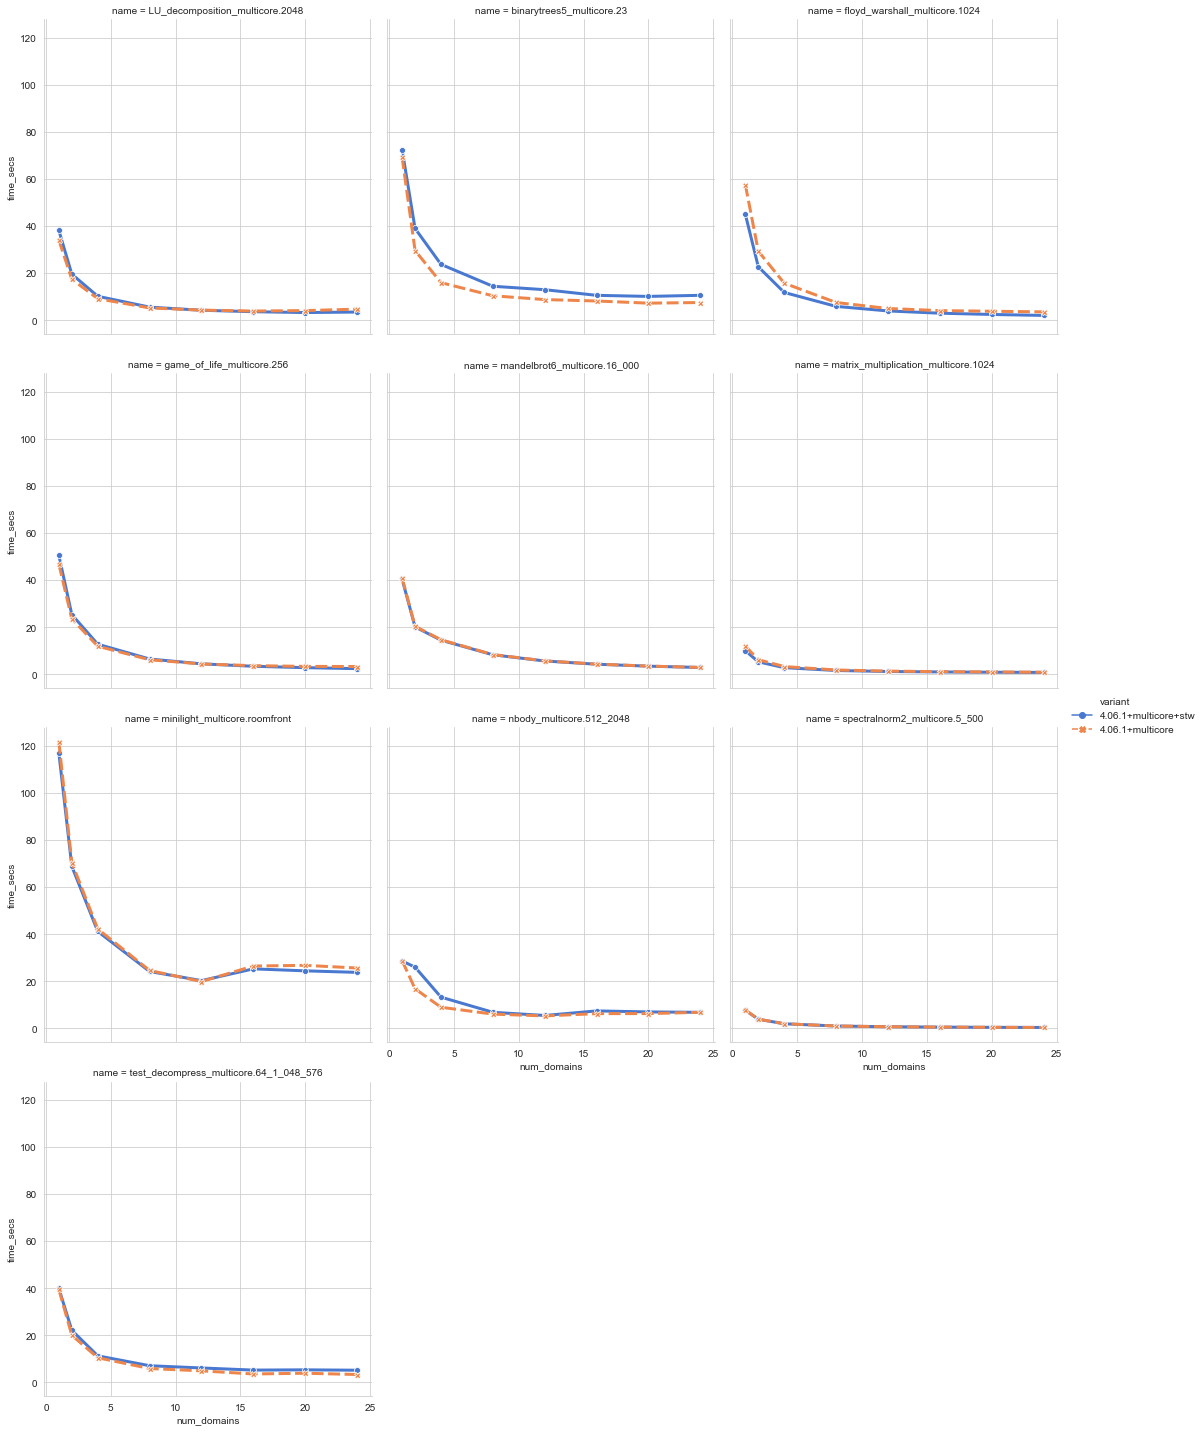

In [4]:
mdf = mdf.sort_values(['name'])
sns.relplot(x='num_domains', y = 'time_secs', hue='variant', col='name',
            data=mdf, kind='line', style='variant', markers=True, col_wrap = 3, 
            lw=3, palette="muted")

## Speedup

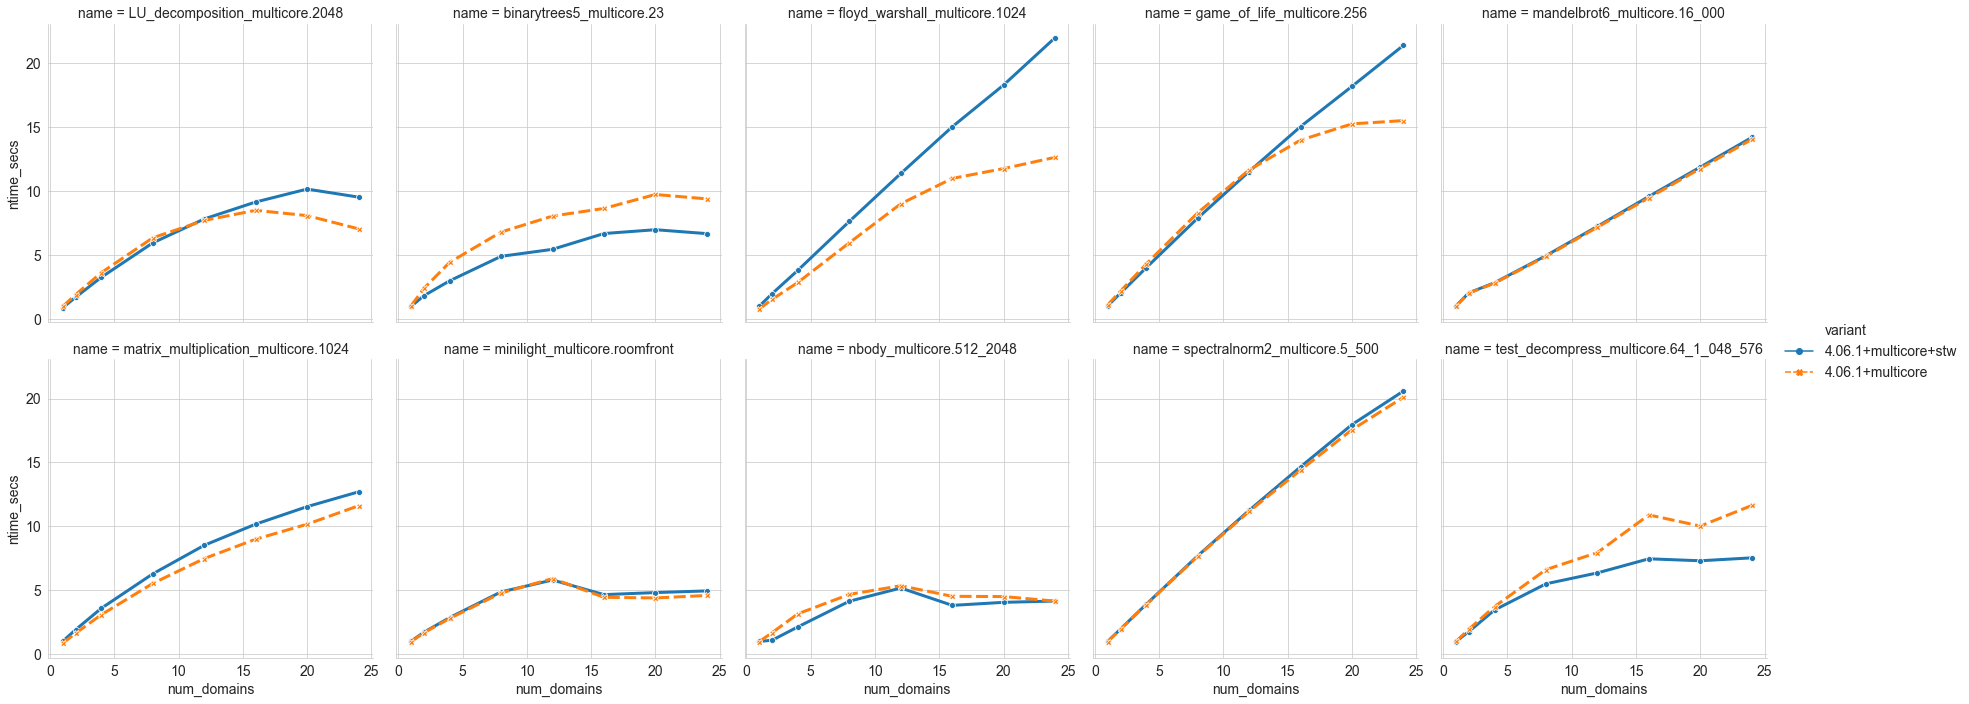

In [5]:
mdf = mdf.sort_values(['name'])
with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                              "legend.fontsize":14}):
    sns.relplot(x='num_domains', y = 'ntime_secs', hue='variant', col='name',
                data=mdf, kind='line', style='variant', markers=True, col_wrap = 5, 
                lw=3)


# Latency

In [6]:
data_frames = []

for file in glob.glob("*.pausetimes_multicore.bench"):
    with open(file) as f:
        data = []
        for l in f:
            data.append(json.loads(l))
        df = pdjson.json_normalize(data)
        df['variant'] = file.replace(".pausetimes_multicore.bench","")
        data_frames.append(df)

df2 = pd.concat(data_frames, sort=False)

mdf2 = df2.loc[df2['name'].str.contains('.*multicore.*',regex=True),:]
mdf2['num_domains'] = mdf2['name'].str.split('.',expand=True)[1].str.split('_',expand=True)[0]
mdf2['num_domains'] = pd.to_numeric(mdf2['num_domains'])
mdf2['name'] = mdf2['name'].replace('\..*?_','.',regex=True)

latency_df = pd.DataFrame.copy(mdf2)
mdf2.sort_values(["name"])

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cavea

,name,mean_latency,max_latency,distr_latency,variant,num_domains
0,LU_decomposition_multicore.2048,1.466052e+04,1984742,"[59, 180, 12030, 13981, 15188, 16062, 17160, 1...",4.06.1+multicore+stw+pausetimes+parallel,12
41,LU_decomposition_multicore.2048,2.193031e+04,2047681,"[59, 75, 273, 21929, 24360, 26420, 28646, 3138...",4.06.1+multicore+stw+pausetimes+parallel,20
67,LU_decomposition_multicore.2048,2.977826e+03,1989167,"[685, 1153, 1205, 1259, 1322, 1414, 1973, 5157...",4.06.1+multicore+pausetimes+parallel,4
63,LU_decomposition_multicore.2048,2.597307e+03,2171641,"[1148, 1213, 1267, 1313, 1350, 1393, 1487, 384...",4.06.1+multicore+pausetimes+parallel,2
63,LU_decomposition_multicore.2048,9.582130e+03,2039512,"[6061, 6347, 7067, 7323, 7757, 8864, 10306, 12...",4.06.1+multicore+stw+pausetimes+parallel,2
67,LU_decomposition_multicore.2048,1.041016e+04,2006313,"[5607, 6900, 7411, 8100, 8967, 10229, 11113, 1...",4.06.1+multicore+stw+pausetimes+parallel,4
41,LU_decomposition_multicore.2048,8.400926e+03,3215850,"[240, 930, 1407, 1929, 2778, 5686, 7204, 9602,...",4.06.1+multicore+pausetimes+parallel,20
87,LU_decomposition_multicore.2048,1.196541e+04,2051519,"[73, 8001, 9006, 10396, 11605, 12278, 13047, 1...",4.06.1+multicore+stw+pausetimes+parallel,8
0,LU_decomposition_multicore.2048,4.931000e+03,2456589,"[496, 876, 1393, 1618, 1906, 2768, 6210, 7302,...",4.06.1+multicore+pausetimes+parallel,12
28,LU_decomposition_multicore.2048,6.897608e+03,201619,"[6130, 6167, 6196, 6224, 6255, 6296, 6366, 652...",4.06.1+multicore+stw+pausetimes+parallel,1


## Max latency

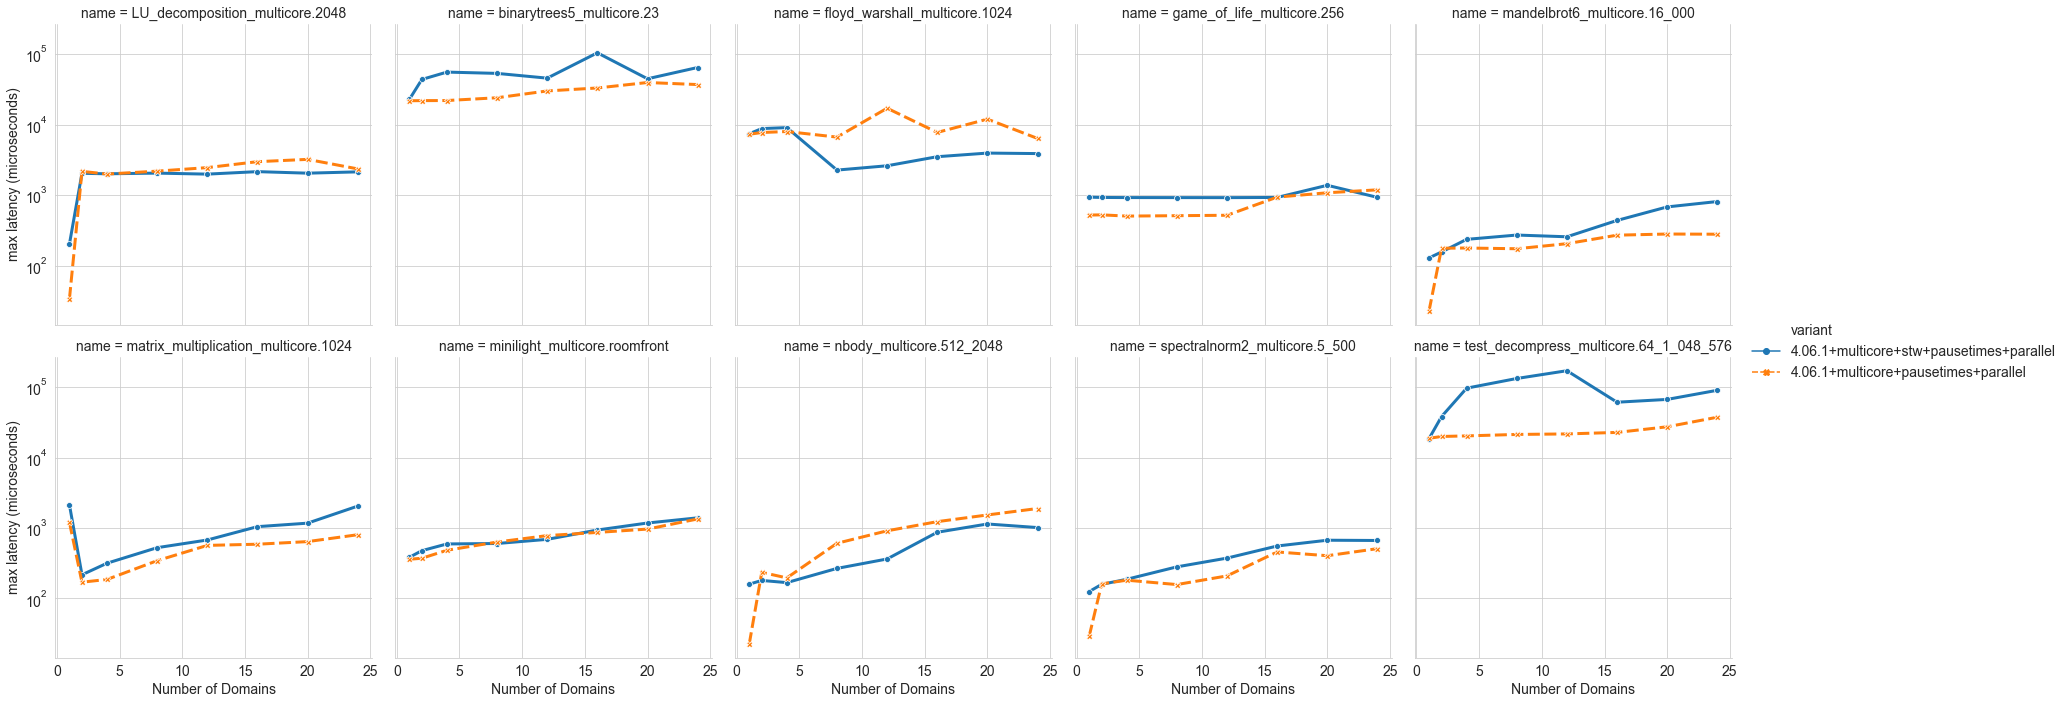

In [7]:
def plotLatencyAt(df,at):
    fdf = df.filter(["name","variant",at + "_latency","num_domains"])
    fdf.sort_values(by="name",inplace=True)
    fdf[at + "_latency"] = fdf[at + "_latency"] / 1000.0
    with sns.plotting_context(rc={"font.size":14,"axes.titlesize":14,"axes.labelsize":14,
                                  "legend.fontsize":14}):
        g = sns.relplot(x='num_domains', y = at + '_latency', hue='variant', col='name',
                        data=fdf, kind='line', style='variant', markers=True, col_wrap = 5, lw=3)
        for ax in g.axes:
            ax.set_ylabel(at + " latency (microseconds)")
            ax.set_xlabel("Number of Domains")
            ax.set_yscale('log')
        
plotLatencyAt(mdf2,"max")

## 99.9th percentile latency

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


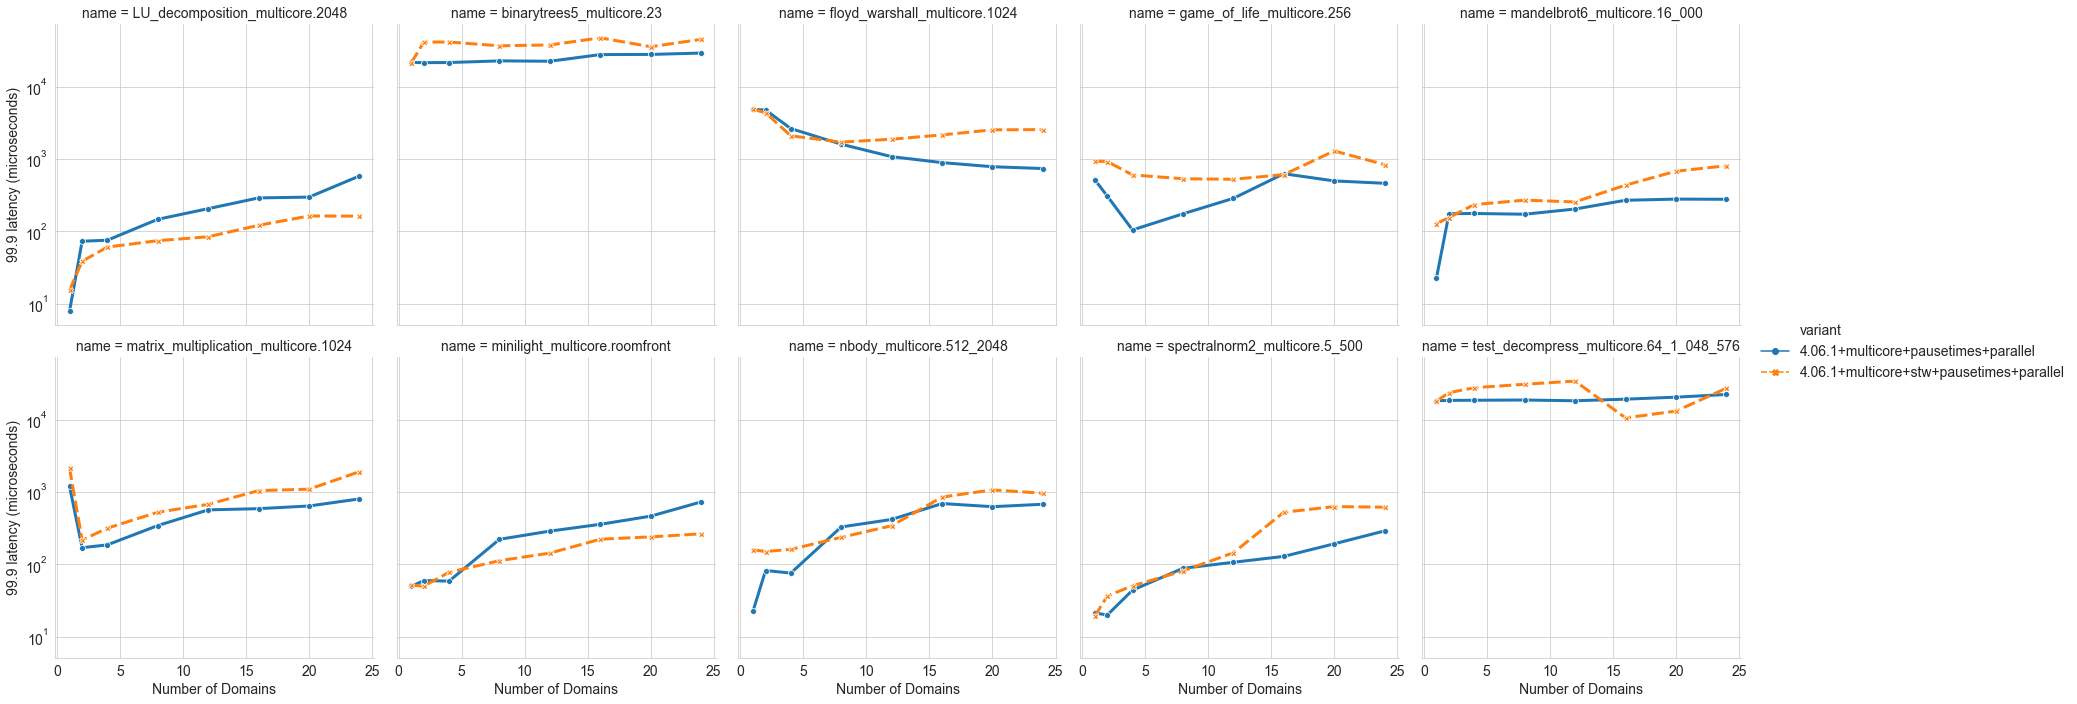

In [8]:
def getLatencyAt(df,percentile,idx):
    groups = df.groupby('variant')
    ndfs = []
    for group in groups:
        (v,df) = group
        for i, row in df.iterrows():
            df.at[i,percentile+"_latency"] = list(df.at[i,"distr_latency"])[idx]
        ndfs.append(df)
    return pd.concat(ndfs)

mdf2 = getLatencyAt(mdf2,"99.9",-1)
plotLatencyAt(mdf2,"99.9")

## 99th percentile latency

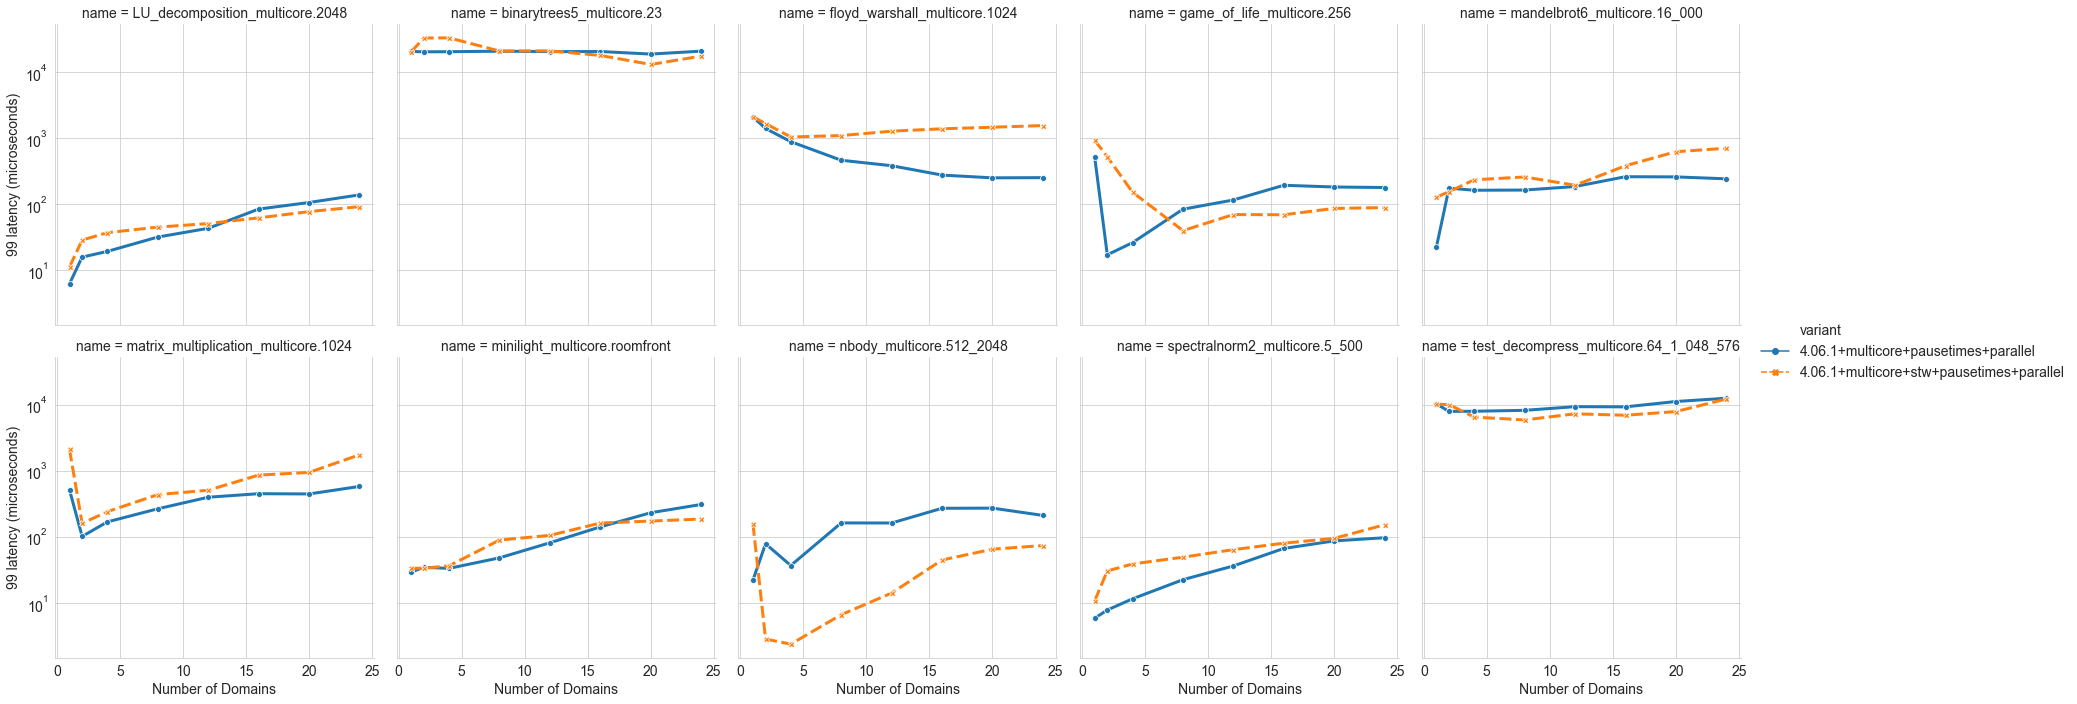

In [9]:
mdf2 = getLatencyAt(mdf2,"99",-2)
plotLatencyAt(mdf2,"99")

## Mean latency

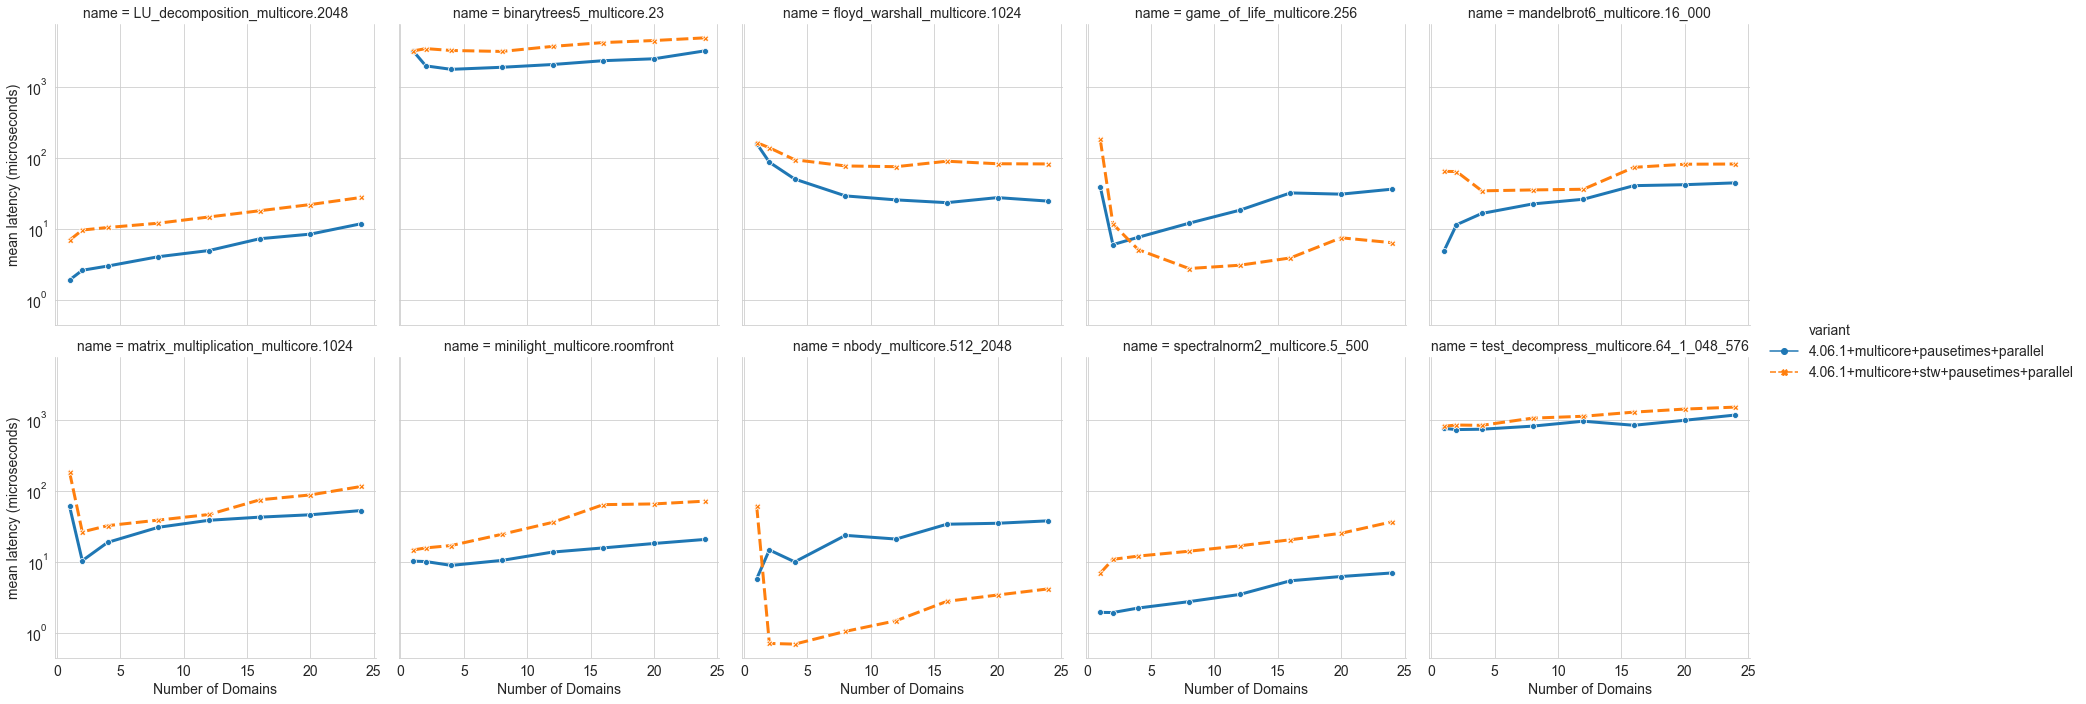

In [10]:
plotLatencyAt(mdf2,"mean")